<a href="https://colab.research.google.com/github/kamyayuki/ronc/blob/main/L31/seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import requests
import json

# Пример запроса к TCIA API, предполагающий JSON формат
url = "https://services.cancerimagingarchive.net/services/v3/TCIA/query/getSeries?Collection=TCGA-BRCA&format=json"
response = requests.get(url)

# Проверка ответа
if response.status_code == 200:
    print("Данные получены успешно")

    # Преобразование ответа в JSON
    try:
        data = response.json()
        if data:
            print(json.dumps(data, indent=4))  # Печать данных в формате JSON с отступами

            # Обработка данных
            for item in data:
                series_instance_uid = item.get('SeriesInstanceUID', 'N/A')
                modality = item.get('Modality', 'N/A')
                protocol_name = item.get('ProtocolName', 'N/A')
                body_part_examined = item.get('BodyPartExamined', 'N/A')

                # Печать извлеченной информации
                print(f"SeriesInstanceUID: {series_instance_uid}")
                print(f"Modality: {modality}")
                print(f"ProtocolName: {protocol_name}")
                print(f"BodyPartExamined: {body_part_examined}")
                print('-' * 30)
        else:
            print("Нет данных для отображения.")
    except json.JSONDecodeError:
        print("Ошибка преобразования ответа в JSON.")
else:
    print(f"Ошибка получения данных. Статус код: {response.status_code}")


Выходные данные были обрезаны до нескольких последних строк (5000).
SeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.6450.4002.240831734808981235886758156447
Modality: MR
ProtocolName: N/A
BodyPartExamined: BREAST
------------------------------
SeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.6450.4002.339963655672432655223423353554
Modality: MR
ProtocolName: N/A
BodyPartExamined: BREAST
------------------------------
SeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.6450.4002.325607836963460379034020654281
Modality: MR
ProtocolName: N/A
BodyPartExamined: BREAST
------------------------------
SeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.6450.4002.282877615330280376078734696973
Modality: MR
ProtocolName: N/A
BodyPartExamined: BREAST
------------------------------
SeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.6450.4002.199532769200268583433474778786
Modality: MR
ProtocolName: N/A
BodyPartExamined: BREAST
------------------------------
SeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.6450.4002.108665300491756890793844

получение изображений

In [10]:
import os
import requests

# Пример использования SeriesInstanceUID
series_instance_uid = "1.3.6.1.4.1.14519.5.2.1.6450.4002.265963154110062013582166845425"  # Пример идентификатора

# URL для загрузки изображений
url = f"https://services.cancerimagingarchive.net/services/v3/TCIA/query/getImage?SeriesInstanceUID={series_instance_uid}"
response = requests.get(url, stream=True)

# Путь для сохранения ZIP-файла
output_path = "/content/images.zip"

# Создание необходимых папок, если их нет
folder_path = os.path.dirname(output_path)
os.makedirs(folder_path, exist_ok=True)

# Проверка ответа и сохранение изображения
if response.status_code == 200:
    print(f"Сохранение файла в {output_path}")
    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=128):
            file.write(chunk)
    print(f"Изображения успешно загружены и сохранены как {output_path}")
else:
    print("Ошибка при загрузке изображений")

Сохранение файла в /content/images.zip
Изображения успешно загружены и сохранены как /content/images.zip


In [11]:
import zipfile

# Распаковка загруженного ZIP-файла
with zipfile.ZipFile("images.zip", 'r') as zip_ref:
    zip_ref.extractall("images")  # Папка для распакованных изображений
print("Файлы успешно распакованы")

Файлы успешно распакованы


In [12]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.5 MB/s eta 0:00:00


In [ ]:
pip install scikit-image

Вывод 20 случайных изображений серии

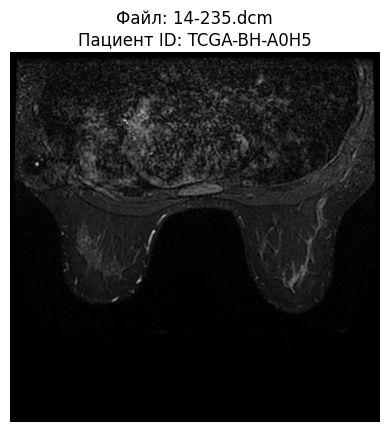

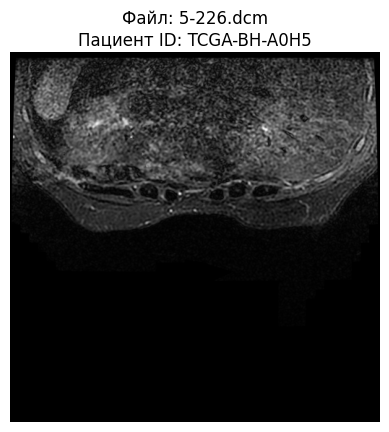

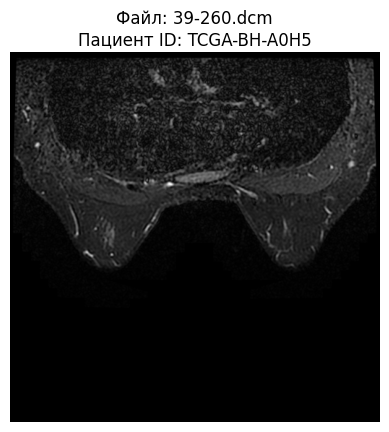

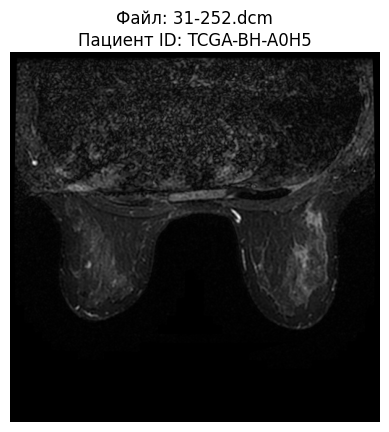

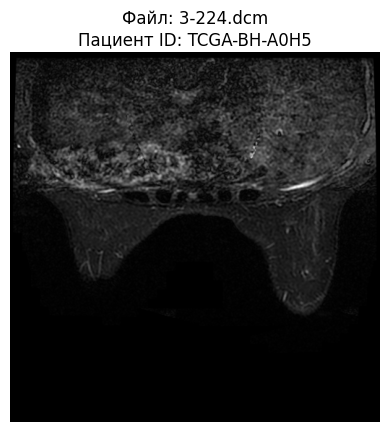

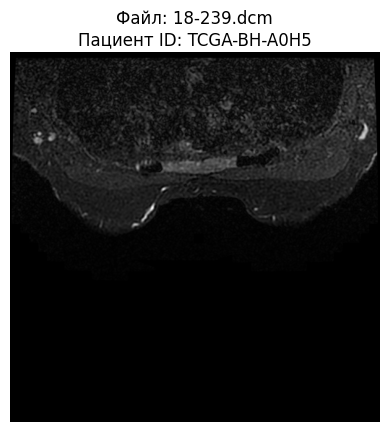

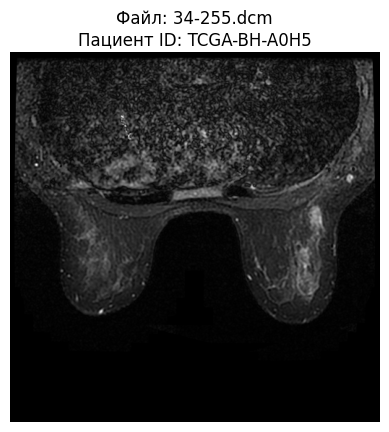

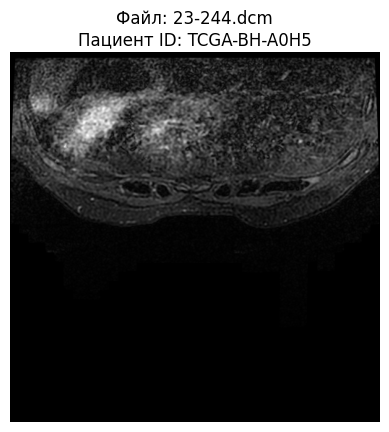

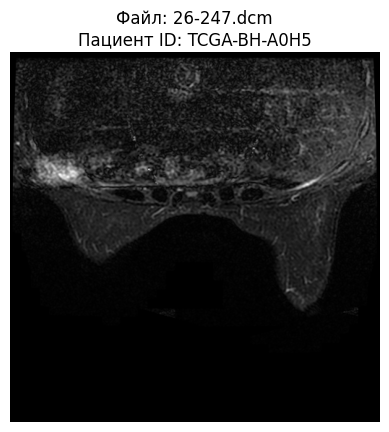

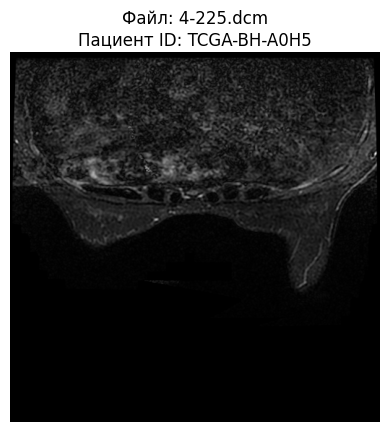

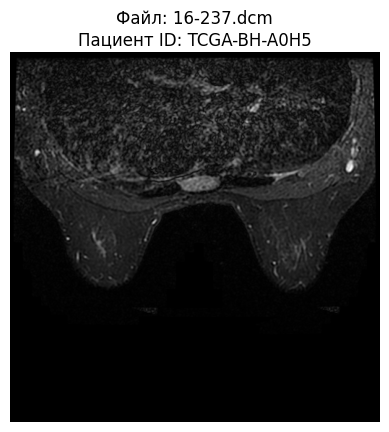

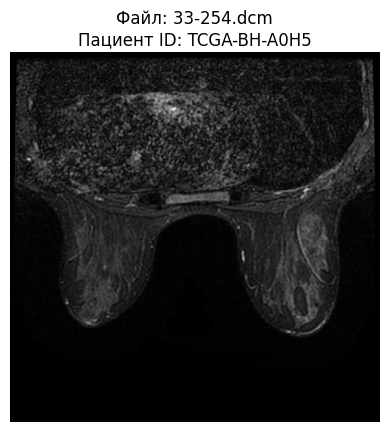

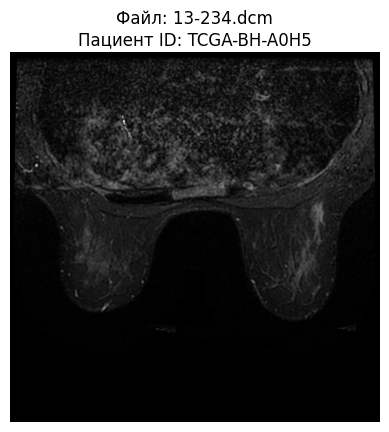

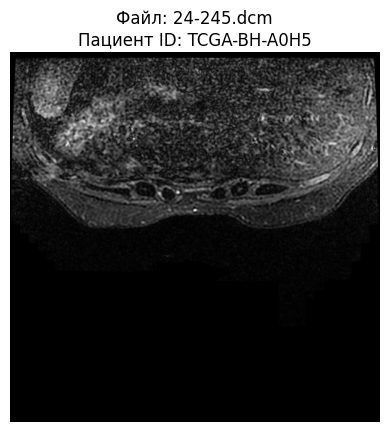

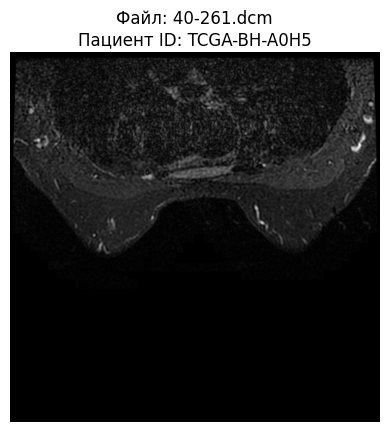

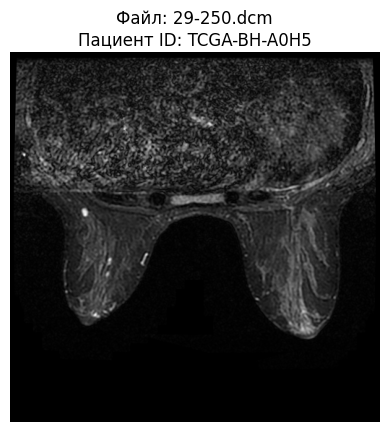

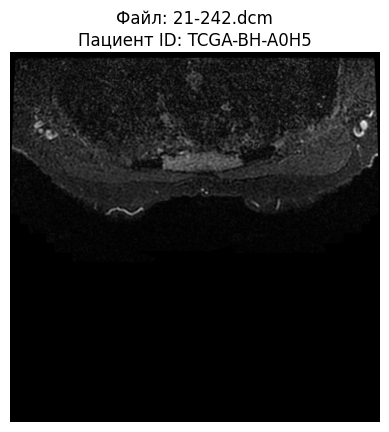

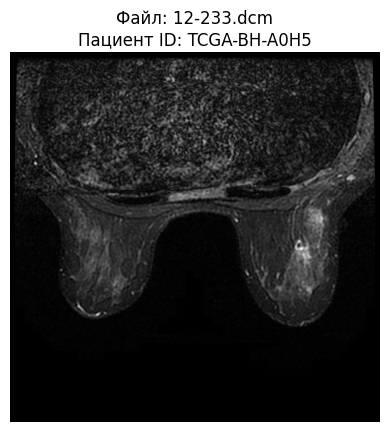

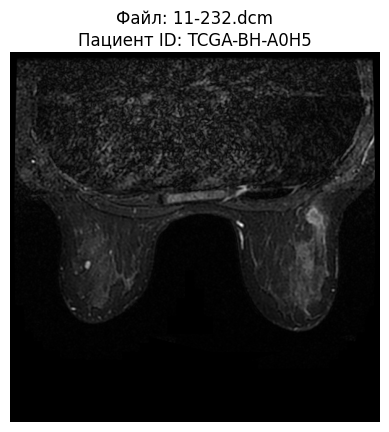

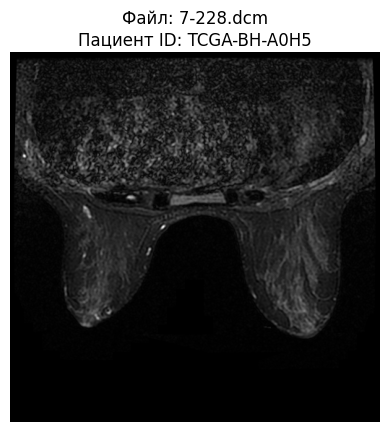

In [ ]:
import os
import random
import pydicom
import matplotlib.pyplot as plt

# Папка с распакованными изображениями
dicom_folder = "images"

# Сбор всех DICOM-файлов в папке
dicom_files = [os.path.join(dicom_folder, filename) for filename in os.listdir(dicom_folder) if filename.endswith(".dcm")]

# Проверка, что в папке достаточно файлов для выбора 20
num_files_to_show = min(20, len(dicom_files))

# Выбор случайных файлов из списка случайным образом
random_files = random.sample(dicom_files, num_files_to_show)

# Визуализация выбранных изображений
for dicom_path in random_files:
    dicom_data = pydicom.dcmread(dicom_path)

    # Получение массива пикселей изображения
    image = dicom_data.pixel_array

    # Визуализация изображения
    filename = os.path.basename(dicom_path)
    plt.imshow(image, cmap="gray")
    plt.title(f"Файл: {filename}\nПациент ID: {dicom_data.PatientID}")
    plt.axis("off")
    plt.show()


После выбора изображениq, применим к нему обработку

Введите названия файлов изображений через запятую: 27-248


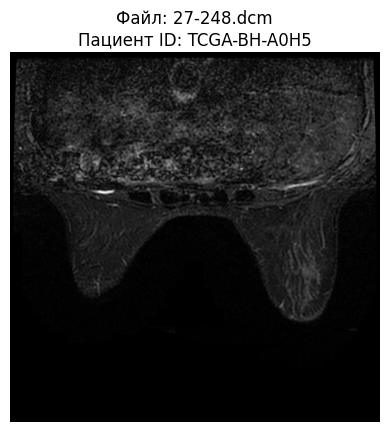

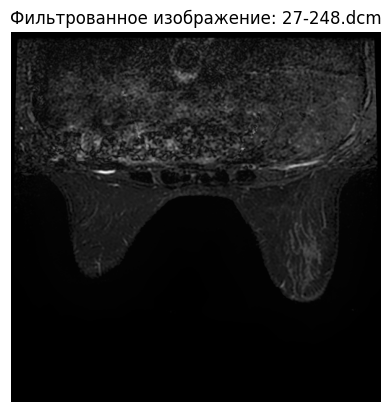

In [ ]:
import os
import random
import pydicom
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage.restoration as restoration

# Папка с распакованными изображениями
dicom_folder = "images"

# Сбор всех DICOM-файлов в папке
dicom_files = [filename for filename in os.listdir(dicom_folder) if filename.endswith(".dcm")]

# Запрос у пользователя названий файлов для отображения
file_names = input("Введите названия файлов изображений через запятую: ").split(",")
file_names = [name.strip() for name in file_names]

# Поиск указанных файлов в папке
selected_files = []
for filename in file_names:
    found_files = [os.path.join(dicom_folder, f) for f in dicom_files if filename in f]
    selected_files.extend(found_files)

# Визуализация выбранных изображений
for dicom_path in selected_files:
    if os.path.exists(dicom_path):
        dicom_data = pydicom.dcmread(dicom_path)

        # Получение массива пикселей изображения
        image = dicom_data.pixel_array

        # Визуализация изображения
        filename = os.path.basename(dicom_path)
        plt.imshow(image, cmap="gray")
        plt.title(f"Файл: {filename}\nПациент ID: {dicom_data.PatientID}")
        plt.axis("off")
        plt.show()

# Применение адаптивного медианного фильтра для улучшения качества изображений перед сегментацией
for dicom_path in selected_files:
    if os.path.exists(dicom_path):
        dicom_data = pydicom.dcmread(dicom_path)
        image = dicom_data.pixel_array

        # Преобразование изображения в формат uint8, если это необходимо
        if image.dtype != np.uint8:
            image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Применение адаптивного медианного фильтра для сглаживания шума
        filtered_image = restoration.denoise_bilateral(image, sigma_color=0.01, sigma_spatial=11, channel_axis=None)

        # Преобразование фильтрованного изображения обратно в формат uint8
        filtered_image = (filtered_image * 255).astype(np.uint8)

        # Визуализация фильтрованного изображения
        filename = os.path.basename(dicom_path)
        plt.imshow(filtered_image, cmap="gray")
        plt.title(f"Фильтрованное изображение: {filename}")
        plt.axis("off")
        plt.show()

**watershed**

Введите названия файлов изображений через запятую: 31-252,28-249


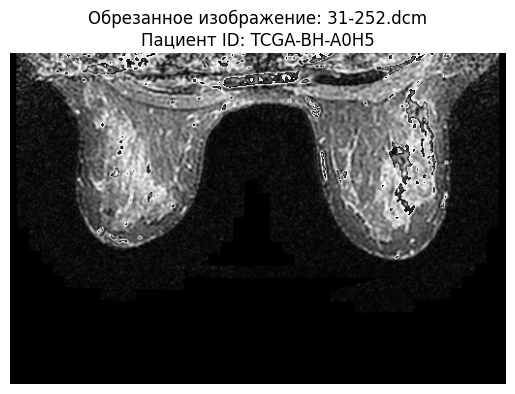

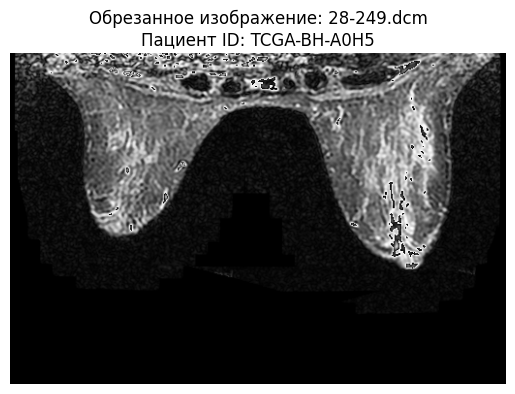

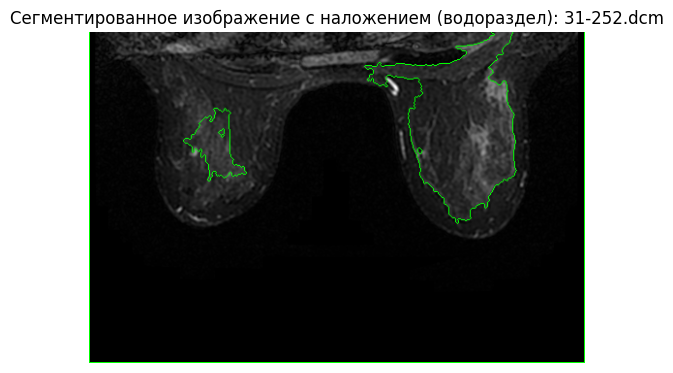

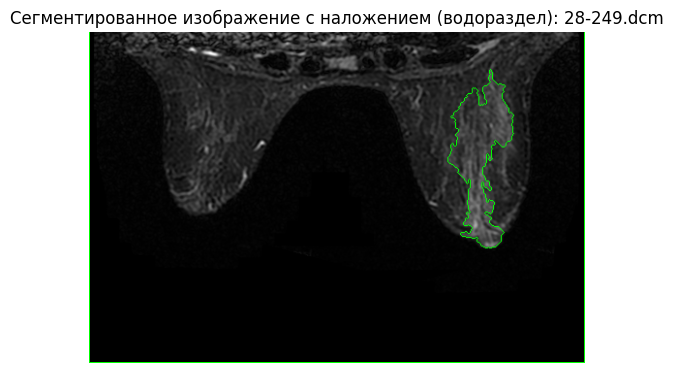

In [ ]:
import os
import random
import pydicom
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage.restoration as restoration

# Папка с распакованными изображениями
dicom_folder = "images"

# Сбор всех DICOM-файлов в папке
dicom_files = [filename for filename in os.listdir(dicom_folder) if filename.endswith(".dcm")]

# Запрос у пользователя названий файлов для отображения
file_names = input("Введите названия файлов изображений через запятую: ").split(",")
file_names = [name.strip() for name in file_names]

# Поиск указанных файлов в папке
selected_files = []
for filename in file_names:
    found_files = [os.path.join(dicom_folder, f) for f in dicom_files if filename in f]
    selected_files.extend(found_files)

# Визуализация выбранных изображений
for dicom_path in selected_files:
    if os.path.exists(dicom_path):
        dicom_data = pydicom.dcmread(dicom_path)

        # Получение массива пикселей изображения
        image = dicom_data.pixel_array

        # Обрезка верхней 1/3 изображения
        height = image.shape[0]
        cropped_image = image[height // 3:, :]

        # Применение адаптивного выравнивания гистограммы (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(3, 3))
        cropped_image = clahe.apply(cropped_image.astype(np.uint8))

        # Визуализация обрезанного изображения
        filename = os.path.basename(dicom_path)
        plt.imshow(cropped_image, cmap="gray")
        plt.title(f"Обрезанное изображение: {filename}\nПациент ID: {dicom_data.PatientID}")
        plt.axis("off")
        plt.show()

# Применение адаптивного медианного фильтра для улучшения качества изображений перед сегментацией
for dicom_path in selected_files:
    if os.path.exists(dicom_path):
        dicom_data = pydicom.dcmread(dicom_path)
        image = dicom_data.pixel_array

        # Обрезка верхней 1/3 изображения
        height = image.shape[0]
        cropped_image = image[height // 3:, :]

        # Преобразование изображения в формат uint8, если это необходимо
        if cropped_image.dtype != np.uint8:
            cropped_image = cv2.normalize(cropped_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Применение адаптивного медианного фильтра для сглаживания шума
        filtered_image = restoration.denoise_bilateral(cropped_image, sigma_color=0.05, sigma_spatial=5, channel_axis=None)

        # Преобразование фильтрованного изображения обратно в формат uint8
        filtered_image = (filtered_image * 255).astype(np.uint8)

        # Применение алгоритма водораздела для сегментации изображения
        # Создание маски для водораздела
        _, binary_image = cv2.threshold(filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        distance_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 5)
        _, sure_fg = cv2.threshold(distance_transform, 0.9 * distance_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(binary_image, sure_fg)

        # Маркировка объектов
        num_markers, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0

        # Применение водораздела
        markers = cv2.watershed(cv2.cvtColor(filtered_image, cv2.COLOR_GRAY2BGR), markers)
        segmented_image = np.zeros_like(filtered_image)
        segmented_image[markers == -1] = 255

        # Наложение сегментированного изображения на исходное с зелеными границами
        original_image_bgr = cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2BGR)
        original_image_bgr[markers == -1] = [0, 255, 0]  # Установка зеленого цвета для границ

        # Визуализация наложенного изображения
        filename = os.path.basename(dicom_path)
        plt.imshow(cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB))
        plt.title(f"Сегментированное изображение с наложением (водораздел): {filename}")
        plt.axis("off")
        plt.show()


thresholding

Введите названия файлов изображений через запятую: 31-252


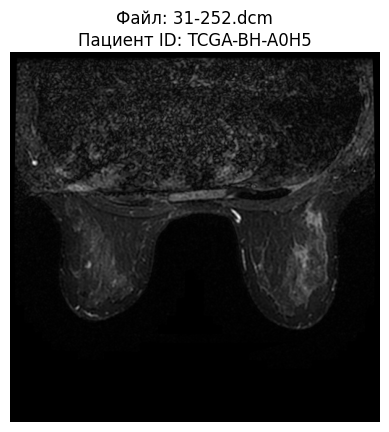

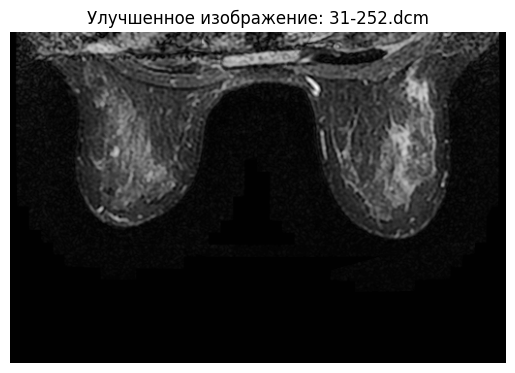

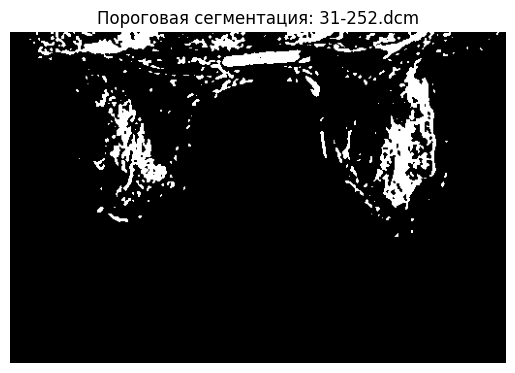

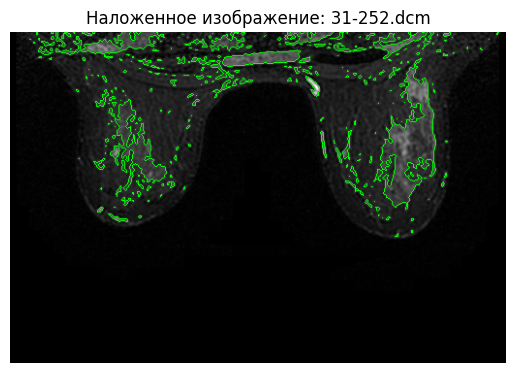

In [ ]:
import os
import random
import pydicom
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Папка с распакованными изображениями
dicom_folder = "images"

# Сбор всех DICOM-файлов в папке
dicom_files = [filename for filename in os.listdir(dicom_folder) if filename.endswith(".dcm")]

# Запрос у пользователя названий файлов для отображения
file_names = input("Введите названия файлов изображений через запятую: ").split(",")
file_names = [name.strip() for name in file_names]

# Поиск указанных файлов в папке
selected_files = []
for filename in file_names:
    found_files = [os.path.join(dicom_folder, f) for f in dicom_files if filename in f]
    selected_files.extend(found_files)

# Визуализация выбранных изображений
for dicom_path in selected_files:
    if os.path.exists(dicom_path):
        dicom_data = pydicom.dcmread(dicom_path)

        # Получение массива пикселей изображения
        image = dicom_data.pixel_array

        # Визуализация изображения
        filename = os.path.basename(dicom_path)
        plt.imshow(image, cmap="gray")
        plt.title(f"Файл: {filename}\nПациент ID: {dicom_data.PatientID}")
        plt.axis("off")
        plt.show()

# Применение обработки изображений перед сегментацией
for dicom_path in selected_files:
    if os.path.exists(dicom_path):
        dicom_data = pydicom.dcmread(dicom_path)
        image = dicom_data.pixel_array

        # Обрезка верхней трети изображения
        height, width = image.shape
        cropped_image = image[height // 3: , :]

        # Преобразование изображения в формат uint8, если это необходимо
        if cropped_image.dtype != np.uint8:
            cropped_image = cv2.normalize(cropped_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Применение адаптивного выравнивания гистограммы для повышения контрастности
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(cropped_image)

        # Визуализация улучшенного изображения
        filename = os.path.basename(dicom_path)
        plt.imshow(enhanced_image, cmap="gray")
        plt.title(f"Улучшенное изображение: {filename}")
        plt.axis("off")
        plt.show()

        # Применение пороговой сегментации
        threshold_value = 100  # Порог можно изменять в зависимости от задачи
        _, thresholded_image = cv2.threshold(enhanced_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Визуализация пороговой сегментации
        plt.imshow(thresholded_image, cmap="gray")
        plt.title(f"Пороговая сегментация: {filename}")
        plt.axis("off")
        plt.show()

        # Наложение сегментированного изображения на исходное с зеленой линией
        contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        overlay_image = cv2.cvtColor(cropped_image, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(overlay_image, contours, -1, (0, 255, 0), 1)

        # Визуализация наложенного изображения
        plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Наложенное изображение: {filename}")
        plt.axis("off")
        plt.show()


FuzzyCmeans

In [ ]:
pip install fuzzy-c-means

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.13.0
    Uninstalling typer-0.13.0:
      Successfully uninstalled typer-0.13.0
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.27.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.


In [ ]:
pip install tabulate>=0.9.0

Обработка изображения - многослойная декомпозиция. Сегментация с Fuzzy C means

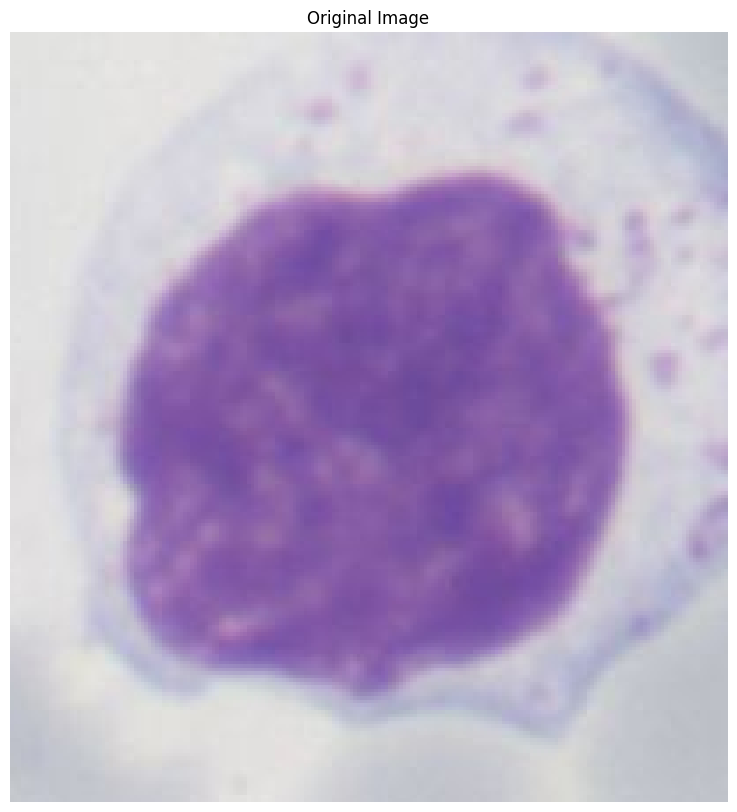

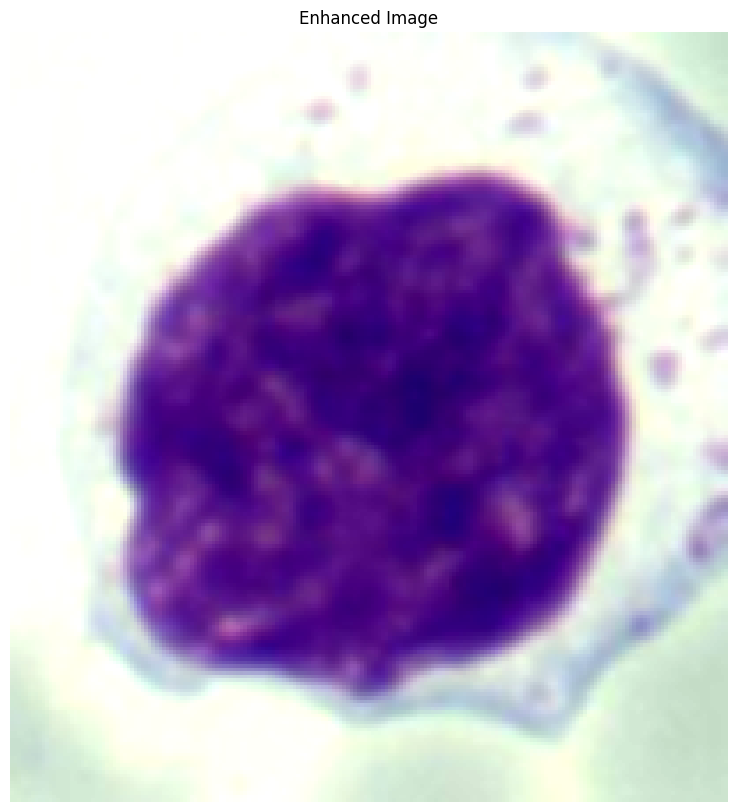

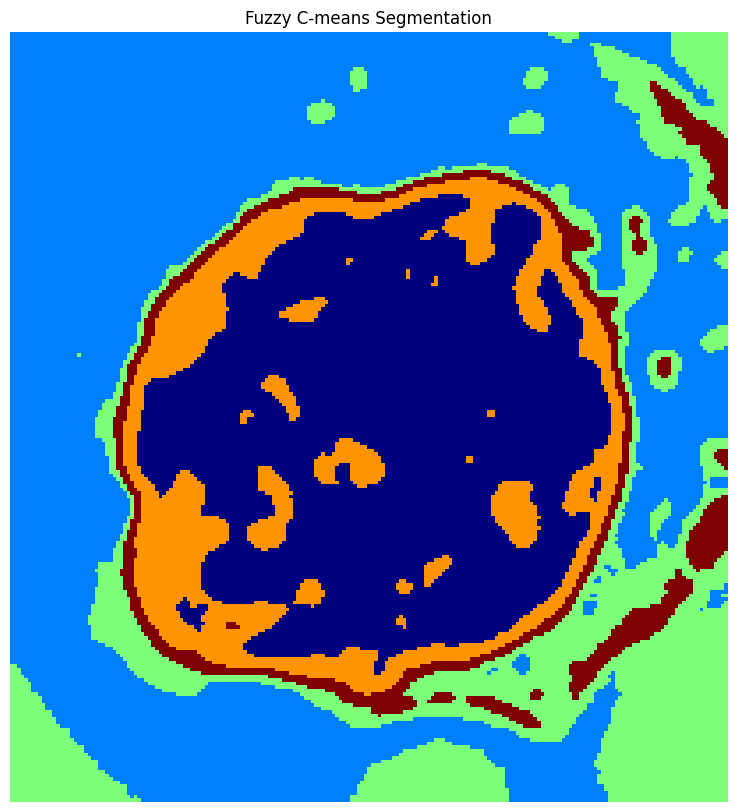

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from fcmeans import FCM  # Для Fuzzy C-means

# Загрузка изображения
image_path = "/content/8.png"  # Укажите путь к вашему изображению
input_image = cv2.imread(image_path)
if input_image is None:
    raise FileNotFoundError(f"Не удалось загрузить изображение по указанному пути: {image_path}")

# Функция для отображения изображения
def show_image(image, title):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Функция для разложения изображения на базовый слой и детали
def multiscale_decomposition(image, kernel_size=5):
    base_layer = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    detail_layer_1 = cv2.subtract(image, base_layer)
    detail_layer_2 = cv2.subtract(base_layer, cv2.GaussianBlur(base_layer, (kernel_size, kernel_size), 0))
    return base_layer, detail_layer_1, detail_layer_2

# Функция для применения сигмоиды к каждому пикселю
def sigmoid(x, a=1):
    return expit(a * x)

# Функция для применения тонового улучшения на основе трехуровневой декомпозиции
def multiscale_tone_enhancement(image, delta_0=1.1, delta_1=2.5, delta_2=2.2, alpha=0.5):
    # Разложение изображения на базовый слой и два слоя детализации
    base_layer, detail_layer_1, detail_layer_2 = multiscale_decomposition(image, kernel_size=5)

    # Среднее значение яркости для каждого канала
    mu = np.mean(base_layer, axis=(0, 1))

    # Применение S-симгмоиды для управления усилением деталей
    S = lambda x: sigmoid((x - mu) / 255.0, a=alpha)

    # Усиление базового слоя и слоев детализации
    enhanced_image = base_layer + delta_0 * (base_layer - mu) + \
                     0.9 * S(detail_layer_1) * (delta_1 * detail_layer_1) + \
                     0.9 * S(detail_layer_2) * (delta_2 * detail_layer_2)

    # Клиппинг результата в допустимый диапазон [0, 255]
    enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)
    return enhanced_image

# Применение тонового улучшения
enhanced_image = multiscale_tone_enhancement(input_image)

# Преобразование изображения в градации серого для FCM
gray_image = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2GRAY)

# Преобразование изображения в формат, подходящий для FCM
reshaped_image = gray_image.flatten().astype(np.float64) / 255.0

# Применение Fuzzy C-means
num_clusters = 5  # Задайте количество кластеров
fcm = FCM(n_clusters=num_clusters)
fcm.fit(reshaped_image.reshape(-1, 1))
cluster_labels = fcm.u.argmax(axis=1)  # Метки кластеров

# Преобразование кластеров в форму изображения
segmented_image = cluster_labels.reshape(gray_image.shape)

# Отображение результатов
show_image(input_image, 'Original Image')
show_image(enhanced_image, 'Enhanced Image')
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image, cmap="jet")
plt.title("Fuzzy C-means Segmentation")
plt.axis('off')
plt.show()


Метод активных контуров - змеек

In [ ]:
pip install scipy

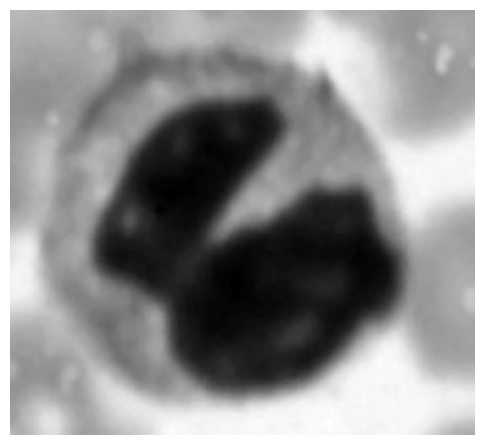

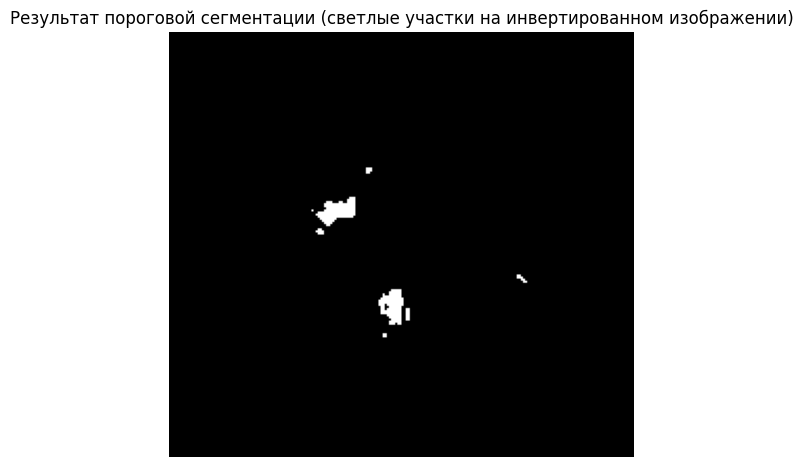

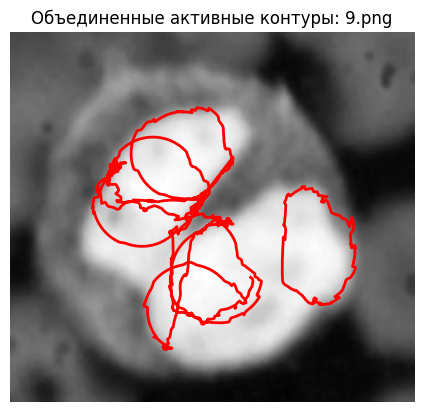

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.segmentation import active_contour
from scipy.spatial import distance

# Функция для применения адаптивного медианного фильтра
def adaptive_median_filter(image, max_kernel_size=5):
    filtered_image = image.copy()
    height, width = image.shape

    for i in range(height):
        for j in range(width):
            kernel_size = 3  # Начальный размер ядра
            while kernel_size <= max_kernel_size:
                # Получаем область с заданным размером ядра
                half_size = kernel_size // 2
                x_start = max(j - half_size, 0)
                x_end = min(j + half_size + 1, width)
                y_start = max(i - half_size, 0)
                y_end = min(i + half_size + 1, height)

                region = image[y_start:y_end, x_start:x_end]
                median_value = np.median(region)

                # Если медианное значение близко к текущему пикселю, увеличиваем размер ядра
                if abs(median_value - image[i, j]) < 10:  # Порог можно настроить
                    break
                kernel_size += 2  # Увеличиваем размер ядра, проверяя на большее
            filtered_image[i, j] = median_value

    return filtered_image

# Функция для объединения пересекающихся контуров
def merge_contours(contours, min_distance=10):
    merged_contours = []

    while contours:
        contour = contours.pop(0)
        merged = False
        for i, existing_contour in enumerate(merged_contours):
            # Проверяем, пересекаются ли контуры (минимальное расстояние между точками)
            if any(distance.euclidean(point, existing_point) < min_distance for point in contour for existing_point in existing_contour):
                # Если контуры пересекаются, объединяем их
                merged_contours[i] = np.vstack((existing_contour, contour))
                merged = True
                break
        if not merged:
            merged_contours.append(contour)

    return merged_contours

# Загрузка изображения (например, PNG)
image_path = "/content/9.png"  # Укажите путь к вашему изображению
input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if input_image is None:
    raise FileNotFoundError(f"Не удалось загрузить изображение по указанному пути: {image_path}")

# Обрезка верхней трети изображения (три восьмых сверху)
cropped_image = input_image

# Преобразование изображения в формат uint8, если это необходимо
if cropped_image.dtype != np.uint8:
    cropped_image = cv2.normalize(cropped_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Применение адаптивного медианного фильтра
adaptive_filtered = adaptive_median_filter(cropped_image)

# Визуализация результата CLAHE
plt.figure(figsize=(6, 6))
plt.imshow(adaptive_filtered, cmap="gray")
plt.axis("off")
plt.show()

# Инвертирование изображения перед сегментацией
inverted_image = np.invert(adaptive_filtered)

# Применение пороговой сегментации для выделения светлых участков на инвертированном изображении
gray_threshold = np.percentile(inverted_image, 90)  # Порог для серых участков, 70-й перцентиль
binary_image = inverted_image > gray_threshold  # Выделяем светлые участки

# Визуализация результата пороговой сегментации
plt.figure(figsize=(6, 6))
plt.imshow(binary_image, cmap="gray")
plt.title("Результат пороговой сегментации (светлые участки на инвертированном изображении)")
plt.axis("off")
plt.show()

# Найдем контуры светлых областей на бинаризованном изображении
contours, _ = cv2.findContours(binary_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Отсортируем контуры по площади и выберем 2 самых крупных
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:6]  # Выбираем только 2 контуры

# Генерация начальных точек для активных контуров
init_points = []
for contour in contours:
    # Найдем центры контуров
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        init_points.append((cy, cx))

# Инициализация контуров с центрами
init_contours = []
for point in init_points:
    y, x = point
    s = np.linspace(0, 2 * np.pi, 400)
    r = y + 30 * np.sin(s)
    c = x + 30 * np.cos(s)
    init = np.array([r, c]).T
    init_contours.append(init)

# Применение метода активных контуров
fig, ax = plt.subplots()
ax.imshow(inverted_image, cmap="gray")  # Выводим контуры на исходном изображении

# Объединяем пересекающиеся контуры
merged_contours = merge_contours(init_contours, min_distance=1)

# Отображаем объединенные контуры
for init in merged_contours:
    snake = active_contour(inverted_image, init, alpha=0.05, beta=0.1, gamma=0.00001)  # Параметры активного контура
    snake[:, 0] = np.clip(snake[:, 0], 0, inverted_image.shape[0] - 1)  # ограничиваем по оси Y
    snake[:, 1] = np.clip(snake[:, 1], 0, inverted_image.shape[1] - 1)  # ограничиваем по оси X

    # Проверяем, чтобы контуры не были в темных областях
    contour_values = inverted_image[tuple(snake.astype(int).T)]

    # Если средняя яркость вдоль контура больше порога, рисуем контур
    if np.mean(contour_values) >100:  # Порог для яркости, можно настроить
        ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)

ax.set_title(f"Объединенные активные контуры: {os.path.basename(image_path)}")
ax.axis("off")
plt.show()


Введите названия файлов изображений через запятую: 30-251


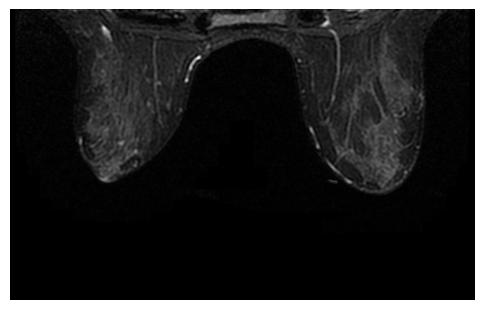

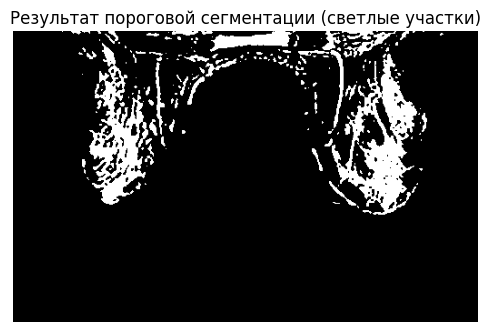

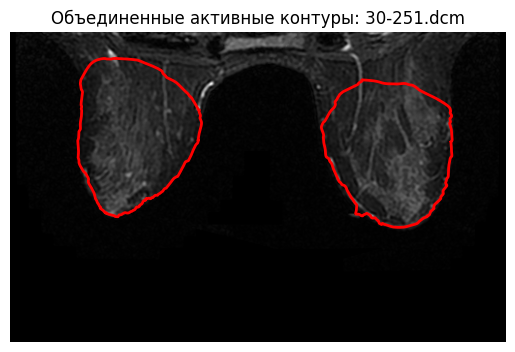

In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.segmentation import active_contour
from scipy.spatial import distance
from skimage.morphology import disk

# Папка с распакованными изображениями
dicom_folder = "images"

# Сбор всех DICOM-файлов в папке
dicom_files = [filename for filename in os.listdir(dicom_folder) if filename.endswith(".dcm")]

# Запрос у пользователя названий файлов для отображения
file_names = input("Введите названия файлов изображений через запятую: ").split(",")
file_names = [name.strip() for name in file_names]

# Поиск указанных файлов в папке
selected_files = []
for filename in file_names:
    found_files = [os.path.join(dicom_folder, f) for f in dicom_files if filename in f]
    selected_files.extend(found_files)

# Функция для применения адаптивного медианного фильтра
def adaptive_median_filter(image, max_kernel_size=15):
    filtered_image = image.copy()
    height, width = image.shape

    for i in range(height):
        for j in range(width):
            kernel_size = 3  # Начальный размер ядра
            while kernel_size <= max_kernel_size:
                # Получаем область с заданным размером ядра
                half_size = kernel_size // 2
                x_start = max(j - half_size, 0)
                x_end = min(j + half_size + 1, width)
                y_start = max(i - half_size, 0)
                y_end = min(i + half_size + 1, height)

                region = image[y_start:y_end, x_start:x_end]
                median_value = np.median(region)

                # Если медианное значение близко к текущему пикселю, увеличиваем размер ядра
                if abs(median_value - image[i, j]) < 10:  # Порог можно настроить
                    break
                kernel_size += 2  # Увеличиваем размер ядра, проверяя на большее
            filtered_image[i, j] = median_value

    return filtered_image

# Функция для объединения пересекающихся контуров
def merge_contours(contours, min_distance=10):
    merged_contours = []

    while contours:
        contour = contours.pop(0)
        merged = False
        for i, existing_contour in enumerate(merged_contours):
            # Проверяем, пересекаются ли контуры (минимальное расстояние между точками)
            if any(distance.euclidean(point, existing_point) < min_distance for point in contour for existing_point in existing_contour):
                # Если контуры пересекаются, объединяем их
                merged_contours[i] = np.vstack((existing_contour, contour))
                merged = True
                break
        if not merged:
            merged_contours.append(contour)

    return merged_contours

# Обработка каждого выбранного DICOM файла
for dicom_path in selected_files:
    if os.path.exists(dicom_path):
        dicom_data = pydicom.dcmread(dicom_path)
        image = dicom_data.pixel_array

        # Обрезка верхней трети изображения (три восьмых сверху)
        height, width = image.shape
        cropped_image = image[int(height * 3 / 8):, :]

        # Преобразование изображения в формат uint8, если это необходимо
        if cropped_image.dtype != np.uint8:
            cropped_image = cv2.normalize(cropped_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Применение фильтра для увеличения яркости (CLAHE)
        #clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(1, 1))
        enhanced_image = cropped_image

        # Визуализация результата CLAHE
        plt.figure(figsize=(6, 6))
        plt.imshow(enhanced_image, cmap="gray")
       # plt.title("После CLAHE (выравнивание гистограммы)")
        plt.axis("off")
        plt.show()

        # Применение пороговой сегментации для выделения светлых участков
        gray_threshold = np.percentile(enhanced_image, 90)  # Порог для серых участков, 75-й перцентиль
        binary_image = enhanced_image > gray_threshold  # Выделяем светлые участки

        # Инвертируем бинарное изображение, чтобы контуры были на светлых областях
       # binary_image = np.invert(binary_image)

        # Визуализация результата пороговой сегментации
        plt.figure(figsize=(6, 6))
        plt.imshow(binary_image, cmap="gray")
        plt.title("Результат пороговой сегментации (светлые участки)")
        plt.axis("off")
        plt.show()

        # Найдем контуры светлых областей
        contours, _ = cv2.findContours(binary_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Отсортируем контуры по площади и выберем 3 самых больших
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

        # Генерация начальных точек для активных контуров
        init_points = []
        for contour in contours:
            # Найдем центры контуров
            M = cv2.moments(contour)
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                init_points.append((cy, cx))

        # Инициализация контуров с центрами
        init_contours = []
        for point in init_points:
            y, x = point
            s = np.linspace(0, 2 * np.pi, 400)
            r = y + 90 * np.sin(s)
            c = x + 90 * np.cos(s)
            init = np.array([r, c]).T
            init_contours.append(init)

        # Применение метода активных контуров
        fig, ax = plt.subplots()
        ax.imshow(enhanced_image, cmap="gray")

        # Объединяем пересекающиеся контуры
        merged_contours = merge_contours(init_contours, min_distance=10)

        # Отображаем объединенные контуры
        for init in merged_contours:
            snake = active_contour(enhanced_image, init, alpha=0.1, beta=0.2, gamma=0.001)
            snake[:, 0] = np.clip(snake[:, 0], 0, enhanced_image.shape[0] - 1)  # ограничиваем по оси Y
            snake[:, 1] = np.clip(snake[:, 1], 0, enhanced_image.shape[1] - 1)  # ограничиваем по оси X

            # Теперь проверяем, чтобы контуры не были в темных областях
            contour_values = enhanced_image[tuple(snake.astype(int).T)]

            # Если средняя яркость вдоль контура меньше порога, не рисуем контур
            if np.mean(contour_values) > 0:  # Порог для яркости, можно настроить
                ax.plot(snake[:, 1], snake[:, 0], '-r', lw=2)

        ax.set_title(f"Объединенные активные контуры: {os.path.basename(dicom_path)}")
        ax.axis("off")
        plt.show()


Графы
Графическая визуализация

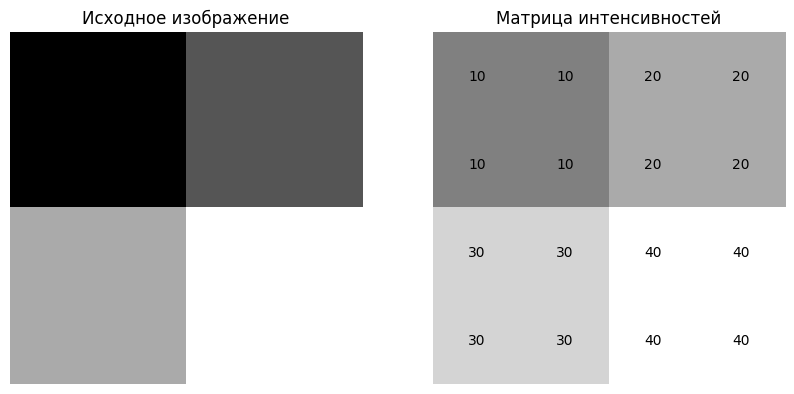

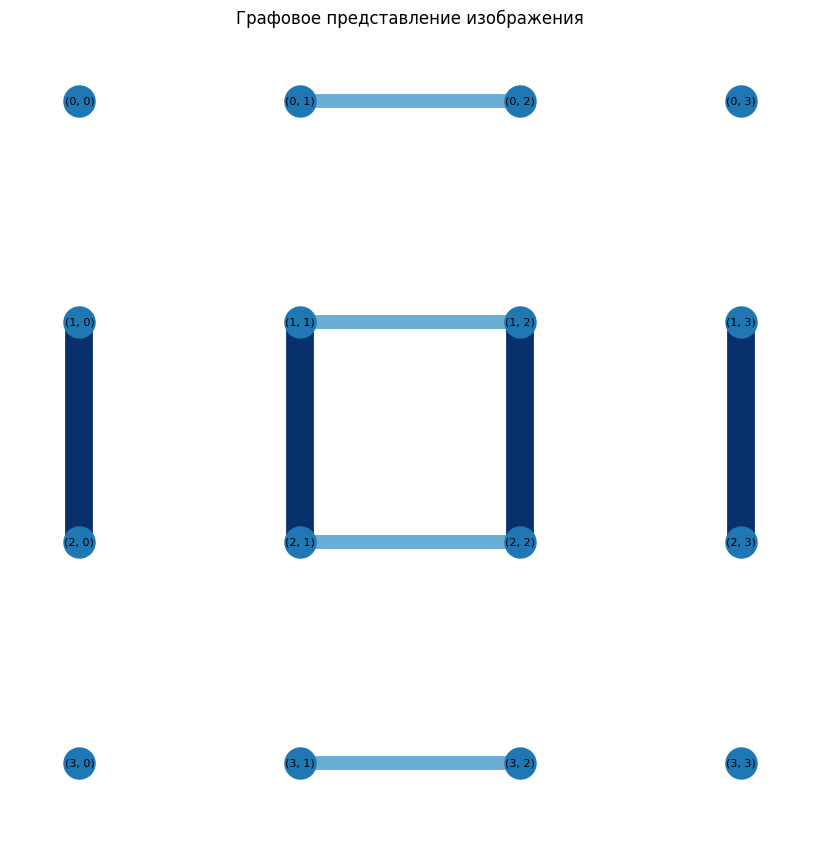

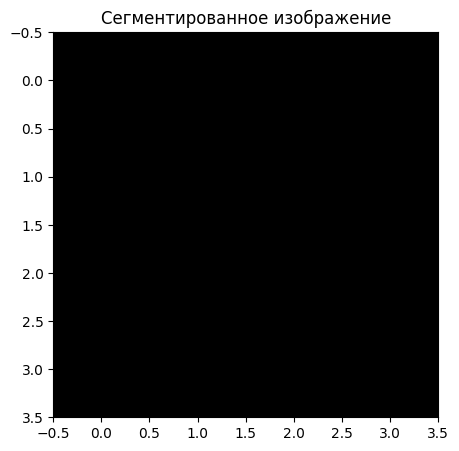

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Создаем простое изображение как матрицу интенсивностей
image = np.array([
    [10, 10, 20, 20],
    [10, 10, 20, 20],
    [30, 30, 40, 40],
    [30, 30, 40, 40]
])

# Визуализируем изображение и матрицу интенсивностей
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Исходное изображение')
ax[0].axis('off')

# Отображаем матрицу интенсивностей на втором графике
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        ax[1].text(j, i, str(image[i, j]), ha='center', va='center', color='black')
ax[1].imshow(image, cmap='gray', alpha=0.5)
ax[1].set_title('Матрица интенсивностей')
ax[1].axis('off')

plt.show()

# Создаем граф из изображения
rows, cols = image.shape
graph = nx.grid_2d_graph(rows, cols)

# Добавляем веса ребрам графа на основе разницы интенсивностей
for i in range(rows):
    for j in range(cols):
        if i < rows - 1:
            weight = np.abs(image[i, j] - image[i + 1, j])
            graph.add_edge((i, j), (i + 1, j), weight=weight)
        if j < cols - 1:
            weight = np.abs(image[i, j] - image[i, j + 1])
            graph.add_edge((i, j), (i, j + 1), weight=weight)

# Визуализируем граф
pos = {(i, j): (j, -i) for i, j in graph.nodes()}
weights = [graph[u][v]['weight'] for u, v in graph.edges()]

plt.figure(figsize=(8, 8))
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=8, width=weights, edge_color=weights, edge_cmap=plt.cm.Blues)
plt.title('Графовое представление изображения')
plt.show()

# Простая сегментация на основе порога веса
threshold = 15
segments = []
for component in nx.connected_components(graph):
    subgraph = graph.subgraph(component)
    if all(graph[u][v]['weight'] <= threshold for u, v in subgraph.edges()):
        segments.append(component)

# Визуализируем сегменты
segmented_image = np.zeros_like(image)
for idx, segment in enumerate(segments, start=1):
    for (i, j) in segment:
        segmented_image[i, j] = 255 - (idx * 50)

plt.figure(figsize=(5, 5))
plt.imshow(segmented_image, cmap='gray')
plt.title('Сегментированное изображение')
plt.show()


Сегментация графовым методом минимального разреза

In [30]:
pip install pygraph


  Preparing metadata (setup.py) ... done
  Created wheel for pygraph: filename=PyGraph-0.3.0-py3-none-any.whl size=45365 sha256=44a91ddfffa63fedc9891c38f99f96c69ee4dff4f0f5e7ca7996320ecd2e31b9
  Stored in directory: /root/.cache/pip/wheels/65/0f/fb/73ffcb48053431e29666b25f5ed98e1bfae4e2ede6fb9d2a9f
Successfully built pygraph


Введите названия файлов изображений через запятую: 32-253
Размер обрезанного изображения: (342, 512)


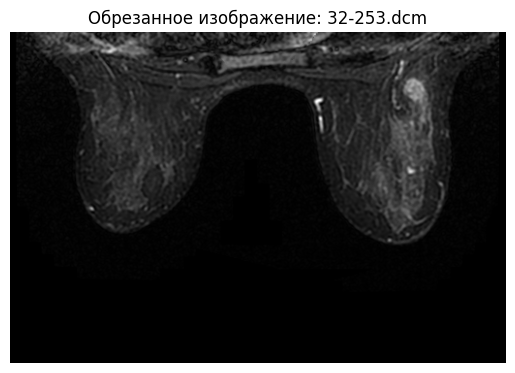

Ошибка: Найден путь с бесконечной пропускной способностью. Проверьте веса рёбер.


In [59]:
import os
import pydicom
import matplotlib.pyplot as plt
import cv2
import numpy as np
import networkx as nx

# Пример графовой сегментации (графовый минимум разреза)
def graph_cut_segmentation(image, threshold=100, max_weight=100):
    # Преобразуем изображение в бинарное
    ret, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

    # Получаем размеры изображения
    rows, cols = binary_image.shape

    # Создаем граф
    G = nx.grid_2d_graph(rows, cols)

    # Присваиваем веса рёбрам, которые отражают разницу в яркости пикселей
    for i in range(rows):
        for j in range(cols):
            if i < rows - 1:  # Вертикальные рёбра
                weight = np.abs(int(binary_image[i, j]) - int(binary_image[i + 1, j]))
                weight = max(1, min(weight, max_weight))  # Ограничиваем минимальный вес на 1, максимальный на max_weight
                G.add_edge((i, j), (i + 1, j), weight=weight)

            if j < cols - 1:  # Горизонтальные рёбра
                weight = np.abs(int(binary_image[i, j]) - int(binary_image[i, j + 1]))
                weight = max(1, min(weight, max_weight))  # Ограничиваем минимальный вес на 1, максимальный на max_weight
                G.add_edge((i, j), (i, j + 1), weight=weight)

    # Определяем источник и сток (например, верхний левый и нижний правый углы)
    source = (0, 0)
    sink = (rows - 1, cols - 1)

    try:
        # Выполняем минимальный разрез
        cut_value, partition = nx.minimum_cut(G, source, sink)
        reachable, non_reachable = partition

        # Сегментированное изображение
        segmented_image = np.zeros_like(binary_image)

        for (i, j) in reachable:
            segmented_image[i, j] = 255

        for (i, j) in non_reachable:
            segmented_image[i, j] = 0

        return segmented_image

    except nx.NetworkXUnbounded:
        print("Ошибка: Найден путь с бесконечной пропускной способностью. Проверьте веса рёбер.")
        return None


# Папка с распакованными изображениями
dicom_folder = "images"

# Сбор всех DICOM-файлов в папке
dicom_files = [filename for filename in os.listdir(dicom_folder) if filename.endswith(".dcm")]

# Запрос у пользователя названий файлов для отображения
file_names = input("Введите названия файлов изображений через запятую: ").split(",")
file_names = [name.strip() for name in file_names]

# Поиск указанных файлов в папке
selected_files = []
for filename in file_names:
    found_files = [os.path.join(dicom_folder, f) for f in dicom_files if filename in f]
    selected_files.extend(found_files)

# Обработка и сегментация изображений
for dicom_path in selected_files:
    if os.path.exists(dicom_path):
        dicom_data = pydicom.dcmread(dicom_path)
        image = dicom_data.pixel_array

        # Обрезка верхних 40% изображения (оставляем нижние 60%)
        height = image.shape[0]
        cropped_image = image[height // 3:, :]  # Обрезаем верхнюю 40%

        # Проверка размера после обрезки
        print(f"Размер обрезанного изображения: {cropped_image.shape}")

        # Визуализация обрезанного изображения
        plt.imshow(cropped_image, cmap="gray")
        plt.title(f"Обрезанное изображение: {os.path.basename(dicom_path)}")
        plt.axis("off")
        plt.show()

        # Преобразование изображения в формат uint8, если это необходимо
        if cropped_image.dtype != np.uint8:
            cropped_image = cv2.normalize(cropped_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Применение адаптивного медианного фильтра для сглаживания шума
        filtered_image = cv2.fastNlMeansDenoising(cropped_image, None, 10, 7, 21)

        # Преобразование фильтрованного изображения обратно в формат uint8
        filtered_image = (filtered_image * 255).astype(np.uint8)

        # Применение графового метода сегментации
        segmented_image = graph_cut_segmentation(filtered_image, threshold=70, max_weight=50)

        # Если сегментация прошла успешно, выводим результат
        if segmented_image is not None:
            plt.imshow(segmented_image, cmap="gray")
            plt.title(f"Графовая сегментация (минимальный разрез): {os.path.basename(dicom_path)}")
            plt.axis("off")
            plt.show()


In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.cluster import SpectralClustering
from skimage import restoration
from sklearn.metrics.pairwise import rbf_kernel

# Загрузка и обработка изображения
def process_image(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    image = dicom_data.pixel_array

    # Обрезка верхних 40% изображения (оставляем нижние 60%)
    height = image.shape[0]
    cropped_image = image[height // 3:, :]  # Обрезаем верхнюю 40%

    # Преобразование изображения в формат uint8, если это необходимо
    if cropped_image.dtype != np.uint8:
        cropped_image = cv2.normalize(cropped_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Применение адаптивного медианного фильтра для сглаживания шума
    filtered_image = restoration.denoise_bilateral(cropped_image, sigma_color=0.05, sigma_spatial=5, channel_axis=None)

    # Преобразование фильтрованного изображения обратно в формат uint8
    filtered_image = (filtered_image * 255).astype(np.uint8)

    return filtered_image

# Спектральная сегментация изображения
def spectral_segmentation(image, n_clusters=2):
    # Преобразование изображения в 2D массив (каждый пиксель как точка)
    rows, cols = image.shape
    pixels = image.reshape(-1, 1)  # Ресайзим изображение в одномерный массив

    # Вычисляем схожесть между соседними пикселями с использованием ядра RBF (радиальное базисное ядро)
    similarity_matrix = rbf_kernel(pixels, gamma=0.1)  # gamma - контролирует ширину гауссова ядра

    # Применение спектральной кластеризации
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral.fit_predict(similarity_matrix)

    # Восстановление сегментированного изображения
    segmented_image = labels.reshape(rows, cols)

    return segmented_image

# Папка с распакованными изображениями
dicom_folder = "images"

# Сбор всех DICOM-файлов в папке
dicom_files = [filename for filename in os.listdir(dicom_folder) if filename.endswith(".dcm")]

# Запрос у пользователя названий файлов для отображения
file_names = input("Введите названия файлов изображений через запятую: ").split(",")
file_names = [name.strip() for name in file_names]

# Поиск указанных файлов в папке
selected_files = []
for filename in file_names:
    found_files = [os.path.join(dicom_folder, f) for f in dicom_files if filename in f]
    selected_files.extend(found_files)

# Обработка и сегментация изображений
for dicom_path in selected_files:
    if os.path.exists(dicom_path):
        # Обработка изображения
        filtered_image = process_image(dicom_path)

        # Применение спектральной сегментации
        segmented_image = spectral_segmentation(filtered_image, n_clusters=2)

        # Визуализация сегментированного изображения
        plt.imshow(segmented_image, cmap="tab20b")
        plt.title(f"Спектральная сегментация: {os.path.basename(dicom_path)}")
        plt.axis("off")
        plt.show()


Введите названия файлов изображений через запятую: 34-255


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse import csr_matrix

# Загрузим изображение
image_path = '/content/9.png'  # Укажите путь к изображению
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Чтение в оттенках серого

# Преобразуем изображение в одномерный массив пикселей
rows, cols = image.shape
pixels = image.reshape(-1, 1)  # Каждый пиксель — это отдельная точка

# Строим гауссово ядро для вычисления сходства (или веса рёбер)
similarity_matrix = rbf_kernel(pixels, gamma=0.1)  # gamma — это параметр ширины гауссова ядра

# Преобразуем матрицу сходства в разреженную форму
sparse_similarity_matrix = csr_matrix(similarity_matrix)

# Применяем спектральную кластеризацию с разреженной матрицей
spectral = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=42)
labels = spectral.fit_predict(sparse_similarity_matrix)

# Восстанавливаем сегментированное изображение
segmented_image = labels.reshape(rows, cols)

# Визуализируем оригинальное изображение и сегментированное изображение
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Оригинальное изображение
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Оригинальное изображение")
axes[0].axis('off')

# Сегментированное изображение
axes[1].imshow(segmented_image, cmap='jet')
axes[1].set_title("Сегментированное изображение (Спектральная кластеризация)")
axes[1].axis('off')

plt.tight_layout()
plt.show()
